In [ ]:
import json
import pandas as pd
from types import SimpleNamespace
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

experiments.json structure
- strategies
  - fedadam
    - exp_summary
      - filtered summary dict (convert to dataframe if needed) 
    - split_epoch (split by each local epoch and exp, contain parameters and path to host files)
      - epoch_1
        - exp_0
          - summary: path/to/summary/file (containing only necessary information of exp 0 and epoch 1)
          - client_0
            - fittimes: path/to/fittimes/file
            - energy: path/to/energy/file
            - evalresult: path/to/evalresult/file
            - monitoring: path/to/monitoring/file
            - processes: path/to/processes/file
            - client_log: path/to/client_log/file
            - fitresult: path/to/fitresult/file
            - logs: path/to/logs/file
            - network: path/to/network/file
            - pid: path/to/pid/file
          - client_1
            - ... similar structure as client_0
          - server
            - energy: path/to/energy/file
            - monitoring: path/to/monitoring/file
            - processes: path/to/processes/file
            - results: path/to/results/file
            - logs: path/to/logs/file
            - network: path/to/network/file
            - server_log: path/to/server_log/file
        - exp_1
          - ... similar structure as exp_0
        ...
    - epoch_3 
      ...
  - fedyogi
    - ...


# Training Results

In [2]:
def flwr_pkl(path_to_pkl):
    """
    Load and return the contents of a pickle file.

    Parameters:
    path_to_pkl (str): The path to the pickle file.

    Returns:
    object: The deserialized object from the pickle file.
    """
    with open(path_to_pkl, "rb") as f:
        result = pkl.load(f)
    return result

def read_server(path_to_result):
    """_summary_

    Returns:
        SimpleNamespace[pd.DataFrame]: Contains energy, results as DataFrames
    """
    try :
        results = flwr_pkl(path_to_result)
    except FileNotFoundError as err:
        print(err)
        results = None
        results_df = None
    if results is not None:
        acc_centralized = [acc[1] for acc in results.metrics_centralized["accuracy"][1:]]
        acc_distributed = [acc[1] for acc in results.metrics_distributed["accuracy"]]
        losses_centralized = [loss[1] for loss in results.losses_centralized[1:]] # First loss is evaluated on initial parameters
        losses_distributed = [loss[1] for loss in results.losses_distributed]
        server_round = [i for i in range(1,len(acc_centralized)+1)]
        #print(len(server_round), len(acc_centralized), len(acc_distributed), len(losses_centralized), len(losses_distributed))
        results_df = pd.DataFrame(
            {
                "server_round": server_round,
                "acc_centralized": acc_centralized,
                "acc_distributed": acc_distributed,
                "losses_centralized": losses_centralized,
                "losses_distributed": losses_distributed   
            }
        )
    return results_df

In [3]:
with open('experiments.json','r') as f:
    strategies_dict = json.load(f)

In [15]:
for key_1 in strategies_dict.keys():
    for key_2 in strategies_dict[key_1].keys():
        print(key_1, key_2)
        for key_3 in strategies_dict[key_1][key_2].keys():
            print(strategies_dict[key_1][key_2][key_3]["summary"]['result_folder'].split("/")[-1])

fedavg epoch_1
2024-04-22_20-33-15
2024-04-22_22-40-16
2024-04-23_00-47-05
2024-04-23_02-54-11
2024-04-23_20-07-20
fedavg epoch_3
2024-04-23_23-12-04
2024-04-24_01-54-37
2024-04-24_04-36-51
2024-04-24_20-31-13
2024-04-25_00-47-02
2024-04-25_01-55-05
fedavg epoch_5
2024-04-24_00-20-43
2024-04-24_03-03-04
2024-04-24_05-45-26
2024-04-24_21-40-22
2024-04-24_23-13-43
2024-04-25_03-03-21
fedadam epoch_1
2024-04-09_22-27-20
2024-04-10_00-35-52
2024-04-10_02-44-15
2024-04-10_04-53-04
2024-04-10_20-55-43
fedadam epoch_3
2024-04-11_00-59-41
2024-04-11_03-42-36
2024-04-11_04-51-25
2024-04-11_21-02-52
2024-04-11_23-45-10
fedadam epoch_5
2024-04-10_23-25-52
2024-04-11_02-08-29
2024-04-11_06-00-15
2024-04-11_22-11-41
2024-04-12_00-53-26
fedadagrad epoch_1
2024-04-02_13-53-36
2024-04-02_16-13-25
2024-04-03_14-12-15
2024-04-03_16-44-01
2024-04-05_15-08-54
fedadagrad epoch_3
2024-04-08_12-18-35
2024-04-08_20-31-55
2024-04-08_21-41-41
2024-04-09_00-23-50
2024-04-09_04-41-10
fedadagrad epoch_5
2024-04-08

In [4]:
def read_data_from_dict(strat_dict, strategy, epoch, exp, host, file_type):
    """
    Read data from a dictionary containing paths to data files.
    """
    path = strat_dict[strategy]['split_epoch'][epoch][exp][host][file_type]
    return path

def concat_server_results(strategy, epoch, host, file_type, n_exp = 5):
    """
    Concatenate server results from multiple experiments.
    """
    result_paths = [read_data_from_dict(strategies_dict, strategy, epoch, f'exp_{i}' , host, file_type) for i in range(n_exp)]
    result_dfs = []
    for path in result_paths:
        result_dfs.append(read_server(path))
    results_df = pd.concat(result_dfs, axis=1, keys=[f'exp_{i}' for i in range(n_exp)])
    return results_df

def average_results(results_df, column, n_exp=5):
    """
    Average results from multiple experiments.
    """
    concat = pd.concat([results_df.__getattr__(f'exp_{i}')[column] for i in range(n_exp)],axis=1)
    avg_df = concat.mean(axis=1)
    std_df = concat.std(axis=1)
    lower = avg_df - std_df
    upper = avg_df + std_df
    final_df = pd.DataFrame({f"{column}_avg": avg_df, f"{column}_std": std_df, f"{column}_lower_bound": lower, f"{column}_upper_bound": upper})
    return final_df



In [6]:
epoch = 'epoch_3' 
strategies = ['fedavg', 'fedyogi', 'fedadam', 'fedadagrad']

def compute_strategy_averages_results(strategies, epoch, metric):
    stratavg = []
    for strat in strategies:
        strat_concat = concat_server_results(strat, epoch, 'server', 'results')
        strat_avg = average_results(strat_concat, metric)
        stratavg.append(strat_avg)
    final_data = pd.concat(stratavg, axis=1, keys=strategies)
    return final_data


In [7]:
def plot_results(strategies, epoch, metric):
    """
    Plot results from multiple experiments.
    """
    data = compute_strategy_averages_results(strategies, epoch, metric)
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    for strat in strategies:
        axs.plot(data[strat][f'{metric}_avg'], label=strat)
        axs.fill_between(data[strat].index, data[strat][f'{metric}_lower_bound'], data[strat][f'{metric}_upper_bound'], alpha=0.2)
    plt.legend()
    plt.show()

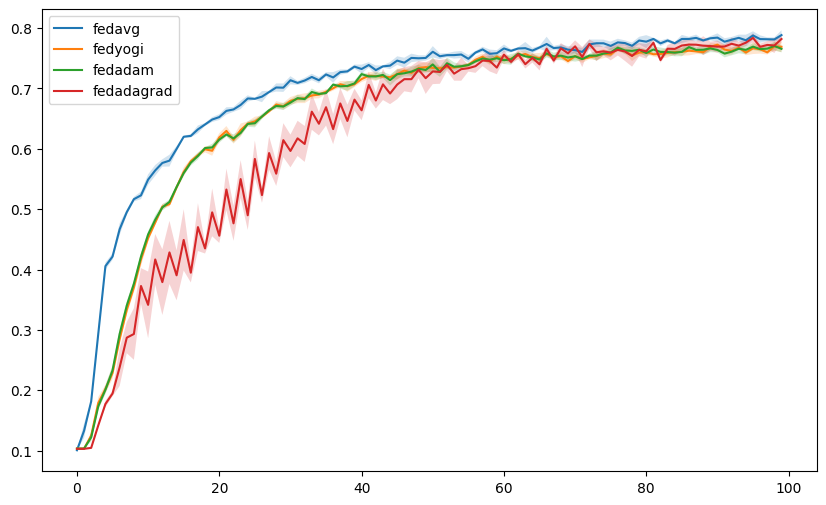

In [8]:
plot_results(strategies, epoch, 'acc_distributed')

# Energy

In [18]:
strategies_dict

{'fedavg': {'epoch_1': {'exp_0': {'summary': {'result_folder': '/home/tunguyen/energyfl/outputcifar10/10clients/fedavg/labelskew/2024-04-22_20-33-15',
     'energy_file': 'energy.csv',
     'server': 'estats-10.toulouse.grid5000.fr',
     'sleep_duration': 30,
     'neuralnet': 'ResNet18',
     'strategy': 'fedavg',
     'optimizer': 'SGD',
     'timestamps.start_experiment_before_sleep': '2024-04-22_20-33-24_819882',
     'timestamps.start_experiment': '2024-04-22_20-33-54_850257',
     'timestamps.end_experiment': '2024-04-22_22-39-35_393811',
     'timestamps.end_experiment_after_sleep': '2024-04-22_22-40-05_405627',
     'params.num_rounds': 300,
     'params.num_clients_per_round_fit': 2,
     'params.num_clients_per_round_eval': 2,
     'params.min_available_clients': 2,
     'params.fraction_fit': 1,
     'params.fraction_evaluate': 1,
     'params.wait_round': 300,
     'params.lr': 0.01,
     'params.num_groups': 32,
     'data.data_name': 'CIFAR10',
     'data.batch_size': 64

In [36]:
import sys
sys.path.append('/home/tunguyen/jetson-test/src')
from utils.process_results import EnergyResult
summary_file = pd.DataFrame(strategies_dict['fedadam']['exp_summary'])
results_dir = summary_file['result_folder'].tolist()
results = []
for path in results_dir:
    energy = EnergyResult(path, summary_file)
    server_result = energy.server_results()
    results.append(server_result)

In [37]:
results[0].results

,server_round,acc_centralized,acc_distributed,losses_centralized,losses_distributed
0,1,0.1000,0.103324,2.359882,2.364786
1,2,0.1000,0.104525,2.427581,2.397412
2,3,0.1000,0.100521,2.592058,2.555595
3,4,0.1494,0.145374,2.605386,2.546612
4,5,0.1611,0.156988,2.461200,2.443294
...,...,...,...,...,...
295,296,0.7847,0.786544,0.791252,0.801201
296,297,0.7840,0.790148,0.804606,0.738777
297,298,0.7838,0.784942,0.813089,0.719009
298,299,0.7844,0.792551,0.821756,0.771452


In [39]:
results[0].energy

,timestamp,RAM%,GPU%,GPU inst power (mW),GPU avg power (mW),CPU%,CPU inst power (mW),CPU avg power (mW),tot inst power (mW),tot avg power (mW)
0,2024-04-09 22:27:31.247488,5,0,0,0,812,2299,2299,7828,7828
1,2024-04-09 22:27:32.230212,4,0,0,0,900,1726,2012,7296,7561
2,2024-04-09 22:27:33.214931,4,0,0,0,400,1151,1581,6684,7121
3,2024-04-09 22:27:34.216773,4,0,0,0,237,1055,1318,6588,6854
4,2024-04-09 22:27:35.216084,4,0,0,0,225,1055,1186,6588,6719
...,...,...,...,...,...,...,...,...,...,...
7683,2024-04-10 00:35:38.120570,5,0,0,0,300,1151,1140,6684,6673
7684,2024-04-10 00:35:39.121637,5,0,0,0,275,1151,1145,6684,6678
7685,2024-04-10 00:35:40.119741,5,0,0,0,300,1151,1148,6684,6681
7686,2024-04-10 00:35:41.120672,5,0,0,0,275,1151,1149,6684,6682
